<a href="https://colab.research.google.com/github/Seji-jam/Generic-Object-Oriented-Plant-Model/blob/main/third_sketch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

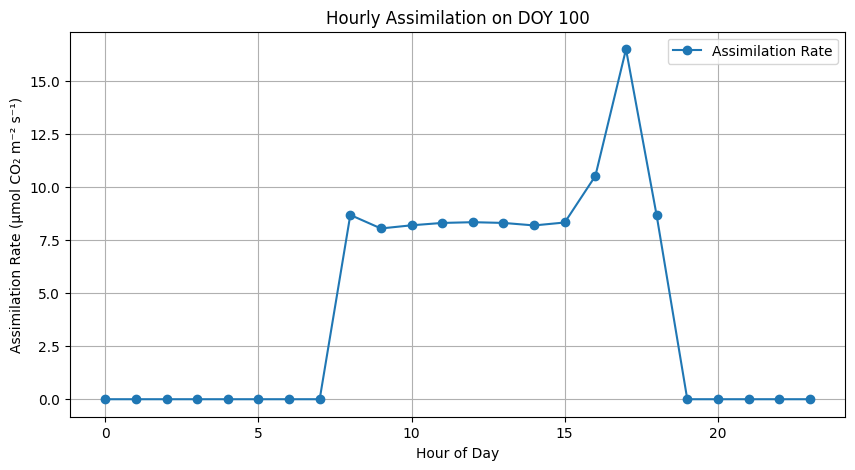

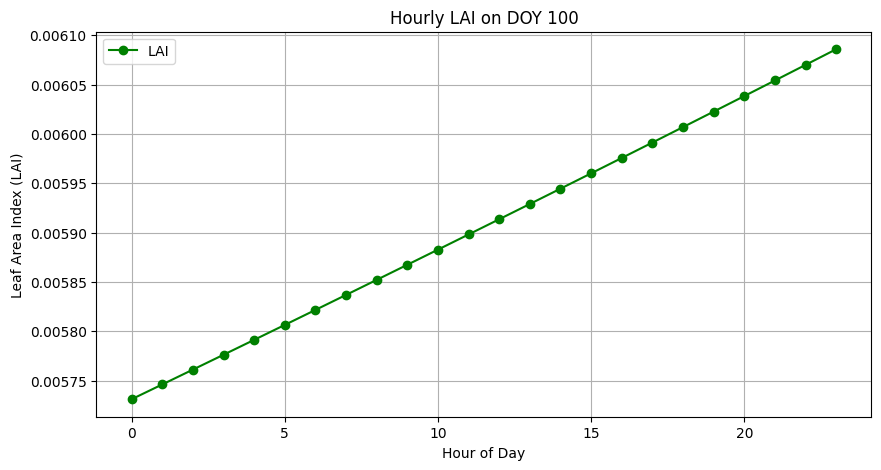

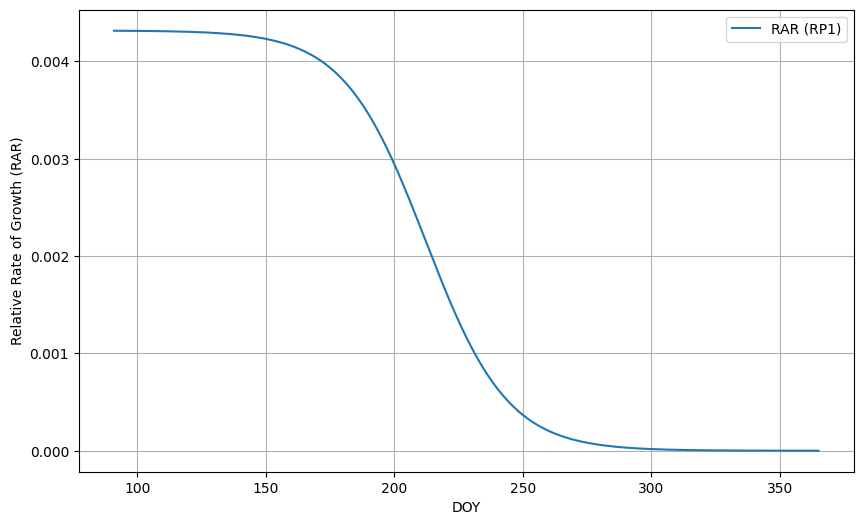

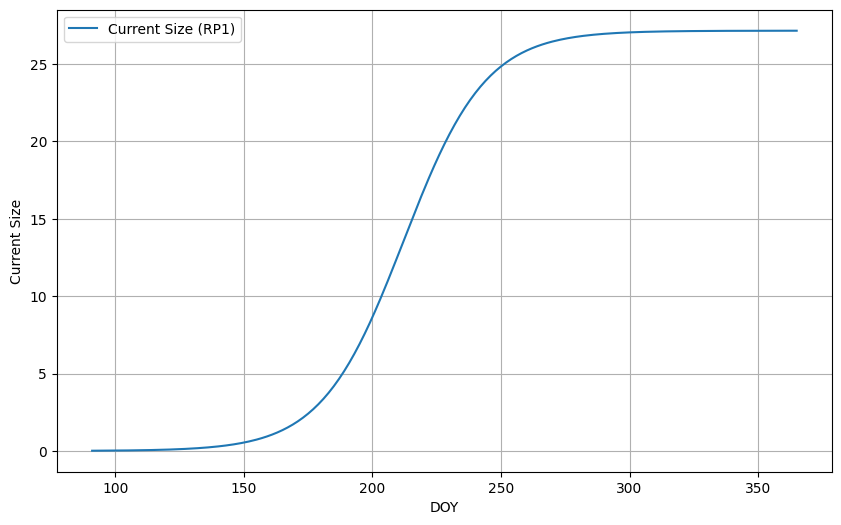

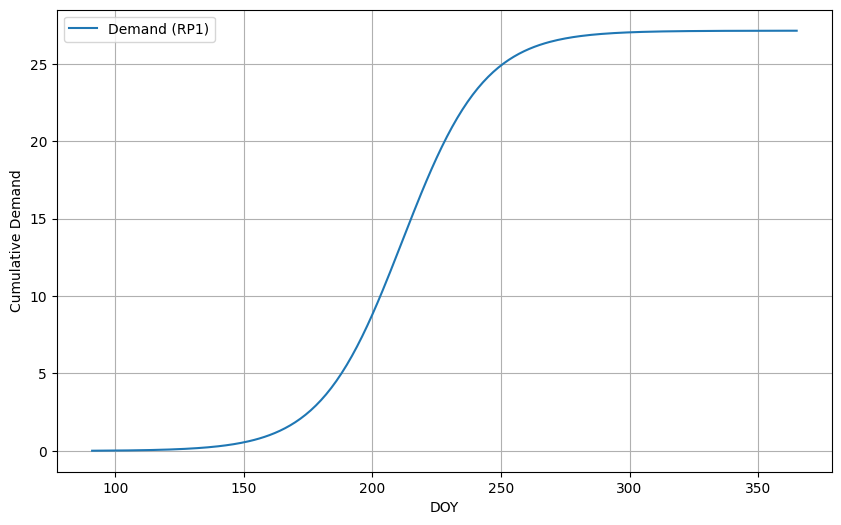

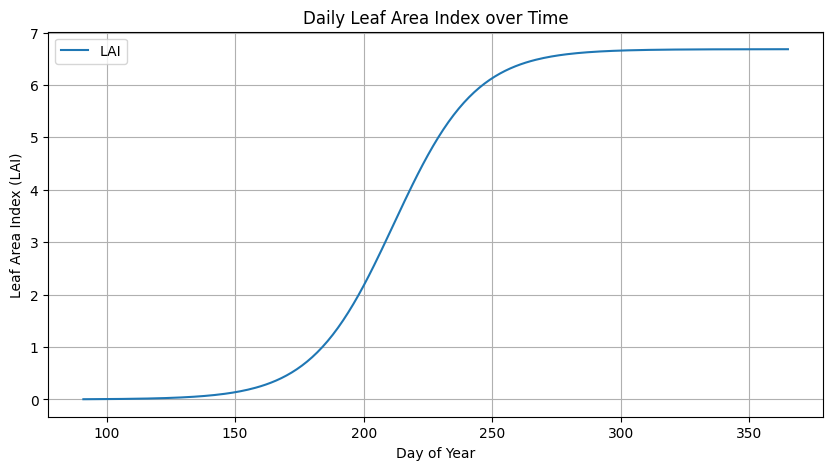

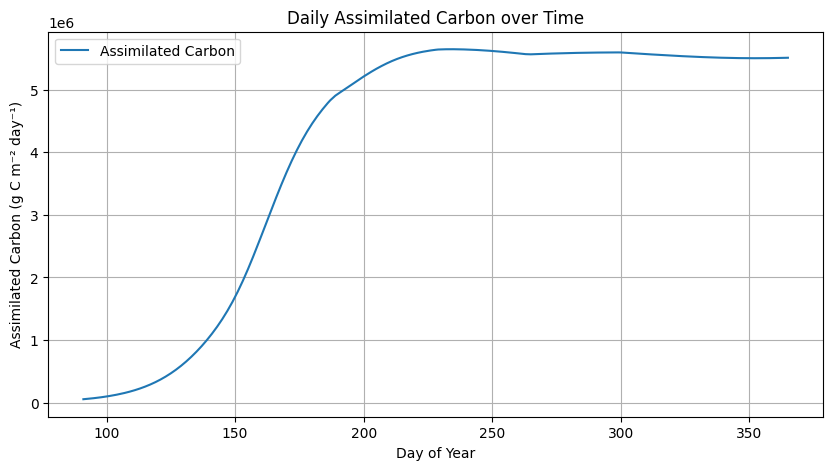

In [ ]:

import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

'''the changes in the hourly assimilations is due to the changes in hourly sin_beam calculations (mostly).
 It is also slightly affected by the sunlit and shaded fraction (which changes during the day due to very sligh changes in LAI)'''

# constant
Activation_Energy_VCMAX = 65330  # Energy of activation for VCMAX (J/mol)
Activation_Energy_Jmax = 43790  # Energy of activation for Jmax (J/mol)
Entropy_Term_JT_Equation = 650  # Entropy term in JT equation (J/mol/K)
Deactivation_Energy_Jmax = 200000  # Energy of deactivation for Jmax (J/mol)
Maximum_Electron_Transport_Efficiency = 0.85  # Maximum electron transport efficiency of PS II
Protons_For_ATP_Synthesis = 3  # Number of protons required to synthesize 1 ATP
O2_Concentration = 210  # Oxygen concentration (mmol/mol)
Scattering_Coefficient_PAR = 0.2  # Leaf scattering coefficient for PAR
Scattering_Coefficient_NIR = 0.8  # Leaf scattering coefficient for NIR
Canopy_Diffuse_Reflection_Coefficient_PAR = 0.057  # Canopy diffuse PAR reflection coefficient
Canopy_Diffuse_Reflection_Coefficient_NIR = 0.389  # Canopy diffuse NIR reflection coefficient
wgauss = np.array([0.1184635, 0.2393144, 0.2844444, 0.2393144, 0.1184635])

# variable inputs
Ambient_CO2 = 400 #(ppm)
Fraction_AboveGround_Carbon=0.65
SLA_Const=0.16
Leaf_Blade_Angle = 45
Activation_Energy_JMAX=48041.88 #(J/mol)
VCMAX=85 #([µmol CO₂ m⁻² s⁻¹])
JMAX=170 #([µmol CO₂ m⁻² s⁻¹])
Photosynthetic_Light_Response_Factor=0.7
BTemp_Phen = 12.0  # Base temperature for phenological development (C)
#OTemp_Phen = 30.0  # Optimum temperature (C)
#CTemp_Phen = 40.0  # Critical temperature (C)
#TempCurve_Res = 0.5  # Temperature response curve factor
# the weather info
#Weather_File = 'https://raw.githubusercontent.com/Seji-jam/Generic-Object-Oriented-Plant-Model/main/v3-0-OOP-operational/Maricopa_WW.xlsx'
#Weather_File = 'https://raw.githubusercontent.com/Seji-jam/Generic-Object-Oriented-Plant-Model/main/v3-0-OOP-operational/Synthetic_Mean.xlsx'
Weather_File = 'https://raw.githubusercontent.com/Seji-jam/Generic-Object-Oriented-Plant-Model/main/v3-0-OOP-operational/hourly_weather_data.csv'


class WeatherMeteo:
    def __init__(self, filename, lat, Simulation_Start_DOY):
        self.filename = filename
        self.lat = lat
        self.Sun_Angle_Inclination = -2
        self.Start_Time = Simulation_Start_DOY
        self.rad = np.pi / 180

    def meteo_calculations(self, doy):
        if not -67 <= self.lat <= 67:
            raise ValueError('ERROR IN meteo_calculations: LAT out of bounds [-67, 67]')

        dec = np.arcsin(np.sin(23.45 * self.rad) * np.cos(2 * np.pi * (doy + 10) / 365))
        Sin_Solar_Declination = np.sin(self.rad * self.lat) * np.sin(dec)
        Cos_Solar_Declination = np.cos(self.rad * self.lat) * np.cos(dec)
        angle_factor = Sin_Solar_Declination / Cos_Solar_Declination

        Day_Length = 12.0 * (1 + 2 * np.arcsin(angle_factor) / np.pi)
        Photoperiod_Day_Length = 12.0 * (1 + 2 * np.arcsin((-np.sin(self.Sun_Angle_Inclination * self.rad) + Sin_Solar_Declination) / Cos_Solar_Declination) / np.pi)
        Daily_Sin_Beam_Exposure = 3600 * (Day_Length * (Sin_Solar_Declination + 0.4 * (Sin_Solar_Declination**2 + Cos_Solar_Declination**2 * 0.5)) +
                             12.0 * Cos_Solar_Declination * (2.0 + 3.0 * 0.4 * Sin_Solar_Declination) * np.sqrt(1.0 - angle_factor**2) / np.pi)
        Solar_Constant = 1367 * (1 + 0.033 * np.cos(2 * np.pi * (doy - 10) / 365))

        return Solar_Constant, Sin_Solar_Declination, Cos_Solar_Declination, Day_Length, Photoperiod_Day_Length, Daily_Sin_Beam_Exposure

    def process_data(self):
        data = pd.read_csv(self.filename)
        data_results = []
        grouped = data.groupby('DOY')

        for doy, group in grouped:
            daily_data = group.iloc[0][['Station', 'Year', 'DOY']].to_dict()
            daily_data['Min_Temp'] = group['Min_Temp'].min()
            daily_data['Max_Temp'] = group['Max_Temp'].max()
            daily_data['Vapour_Pressure'] = group['VPD'].mean()
            daily_data['Wind_Speed'] = group['Wind_Speed'].mean()
            daily_data['Rain'] = group['Rain'].sum()
            daily_data['Solar_Radiation'] = group['Solar_Radiation'].sum()

            # Meteorological calculations
            Solar_Constant, Sin_Solar_Declination, Cos_Solar_Declination, Day_Length, Photoperiod_Day_Length, Daily_Sin_Beam_Exposure = self.meteo_calculations(doy)
            daily_data['Solar_Constant'] = Solar_Constant
            daily_data['Sin_Solar_Declination'] = Sin_Solar_Declination
            daily_data['Cos_Solar_Declination'] = Cos_Solar_Declination
            daily_data['Day_Length'] = Day_Length
            daily_data['Photoperiod_Day_Length'] = Photoperiod_Day_Length
            daily_data['Daily_Sin_Beam_Exposure'] = Daily_Sin_Beam_Exposure

            # Store hourly data
            hourly_data = group[['Hour', 'Solar_Radiation', 'Min_Temp', 'Max_Temp', 'VPD', 'Wind_Speed']].to_dict('records')
            daily_data['Hourly_Data'] = hourly_data

            data_results.append(daily_data)

        return data_results


class Environment:
    def __init__(self, weather_meteo, stress_factor=1.0):
        self.stress_factor = stress_factor
        self.weather_meteo = weather_meteo
        self.weather_data = weather_meteo.process_data()  # This gets processed weather data for all timesteps


class ResourcePool:
    def __init__(self, name, activation_thermal_time, allocation_priority, max_size, growth_rate, N0):
        self.name = name
        self.activation_thermal_time = activation_thermal_time
        self.allocation_priority = allocation_priority
        self.max_size = max_size
        self.growth_rate = growth_rate
        self.N0 = N0
        self.demand=0
        self.rar=0
        self.current_size = N0
        self.is_active = False

    def update_activation_status(self, plant_thermal_time):
        if plant_thermal_time >= self.activation_thermal_time:
            self.is_active = True

    def calc_RAR(self,thermCD, K, N0, r):
        A = (K - N0) / N0
        exp_component = math.exp(-r * thermCD)
        f_prime = (K * A * r * exp_component) / (1 + A * exp_component) ** 2
        f = K / (1 + A * exp_component)
        RAR = f_prime / f
        self.RAR = RAR
        return RAR

    def calculate_demand(self, plant_thermal_time, DeltaThermalTime):
        thermCD = plant_thermal_time - self.activation_thermal_time
        if thermCD < 0:
            thermCD = 0
        RAR = self.calc_RAR(thermCD, self.max_size, self.N0, self.growth_rate)
        demand = RAR * self.current_size *DeltaThermalTime
        self.demand = demand
        return demand

    def receive_carbon(self, allocated_carbon):
        self.current_size += allocated_carbon


class Plant:
    def __init__(self, environment, resource_pools):
        self.environment = environment
        self.current_thermal_time = 0.0
        self.previous_thermal_time = 0.0
        self.assimilated_carbon = 0.0
        self.resource_pools = resource_pools
        self.allocation_log = []
        self.Leaf_Area_Index=0.005
        self.Daily_Thermal_Unit = 0.0
        self.assimilations_Licor = 0.0
        self.Daily_PAR_Sunlit=0
        self.Daily_PAR_Shaded=0
        self.Sunlit_Fr=0
        self.Hourly_Assimilation_Rates = []

    def photosynthesis(self, Absorbed_PAR, Leaf_Temp, Intercellular_CO2, Photosynthetic_Light_Response_Factor,
                       Activation_Energy_Jmax, VCMAX,JMAX):

        temp_factor = 1. / 298. - 1. / (Leaf_Temp + 273.)
        Carboxylation_Temperature_Effect = math.exp(temp_factor * Activation_Energy_VCMAX / 8.314)
        Electron_Transport_Temperature_Effect = (math.exp(temp_factor * Activation_Energy_Jmax / 8.314) *
            (1. + math.exp(Entropy_Term_JT_Equation / 8.314 - Deactivation_Energy_Jmax / 298. / 8.314)) /
            (1. + math.exp(Entropy_Term_JT_Equation / 8.314 - 1. / (Leaf_Temp + 273.) * Deactivation_Energy_Jmax / 8.314)))

        Adjusted_VCMAX = VCMAX * Carboxylation_Temperature_Effect
        Adjusted_JMAX =  JMAX * Electron_Transport_Temperature_Effect

        Photon_Flux_Density = 4.56 * Absorbed_PAR

        KMC = 404.9 * math.exp(temp_factor * 79430 / 8.314)
        KMO = 278.4 * math.exp(temp_factor * 36380 / 8.314)

        CO2_Compensation_No_Respiration = 0.5 * math.exp(-3.3801 + 5220. / (Leaf_Temp + 273.) / 8.314) * O2_Concentration * KMC / KMO

        Quantum_Efficiency_Adjustment = (1 - 0) / (1 + (1 - 0) / Maximum_Electron_Transport_Efficiency)
        Electron_Transport_Ratio = Quantum_Efficiency_Adjustment * Photon_Flux_Density / max(1E-10, Adjusted_JMAX)
        Adjusted_Electron_Transport_Rate = Adjusted_JMAX * (1 + Electron_Transport_Ratio - ((1 + Electron_Transport_Ratio)**2 - 4 * Electron_Transport_Ratio * Photosynthetic_Light_Response_Factor)**0.5) / 2 / Photosynthetic_Light_Response_Factor

        Carboxylation_Rate_Rubisco_Limited = Adjusted_VCMAX * Intercellular_CO2 / (Intercellular_CO2 + KMC * (O2_Concentration / KMO + 1.))
        Carboxylation_Rate_Electron_Transport_Limited = Adjusted_Electron_Transport_Rate * Intercellular_CO2 * (2 + 0 - 0) / Protons_For_ATP_Synthesis / (0 + 3 * Intercellular_CO2 + 7 * CO2_Compensation_No_Respiration) / (1 - 0)

        Gross_Leaf_Photosynthesis = (1 - CO2_Compensation_No_Respiration / Intercellular_CO2) * min(Carboxylation_Rate_Rubisco_Limited, Carboxylation_Rate_Electron_Transport_Limited)
        Gross_Leaf_Photosynthesis = max(1E-10, (1E-6) * 44 * Gross_Leaf_Photosynthesis) # g CO₂ m⁻² s⁻¹

        Net_Photosynthesis = Gross_Leaf_Photosynthesis
        return Net_Photosynthesis

    def KDR_Coeff(self,Solar_Elev_Sin, Leaf_Blade_Angle):
        Solar_Elev_Angle = np.arcsin(Solar_Elev_Sin)
        if Solar_Elev_Sin >= np.sin(Leaf_Blade_Angle):
            Leaf_Orientation_Avg = Solar_Elev_Sin * np.cos(Leaf_Blade_Angle)
        else:
            Leaf_Orientation_Avg = (2 / np.pi) * (Solar_Elev_Sin * np.cos(Leaf_Blade_Angle) * np.arcsin(np.tan(Solar_Elev_Angle) / np.tan(Leaf_Blade_Angle)) + ((np.sin(Leaf_Blade_Angle))**2 - Solar_Elev_Sin**2)**0.5)

        Direct_Beam_Ext_Coeff = Leaf_Orientation_Avg / Solar_Elev_Sin
        return Direct_Beam_Ext_Coeff

    def KDF_Coeff(self, Leaf_Area_Index, Leaf_Blade_Angle, Scattering_Coeff):
        Beam_Ext_Coeff_15 = self.KDR_Coeff(np.sin(15. * np.pi / 180.), Leaf_Blade_Angle)
        Beam_Ext_Coeff_45 = self.KDR_Coeff(np.sin(45. * np.pi / 180.), Leaf_Blade_Angle)
        Beam_Ext_Coeff_75 = self.KDR_Coeff(np.sin(75. * np.pi / 180.), Leaf_Blade_Angle)

        Diffuse_Ext_Coeff = -1 / self.Leaf_Area_Index * np.log(0.178 * np.exp(-Beam_Ext_Coeff_15 * (1.0 - Scattering_Coeff)**0.5 * self.Leaf_Area_Index) +
                            0.514 * np.exp(-Beam_Ext_Coeff_45 * (1.0 - Scattering_Coeff)**0.5 * self.Leaf_Area_Index) +
                            0.308 * np.exp(-Beam_Ext_Coeff_75 * (1.0 - Scattering_Coeff)**0.5 * self.Leaf_Area_Index))
        return Diffuse_Ext_Coeff

    def REFLECTION_Coeff(self,Leaf_Scattering_Coeff, Direct_Beam_Ext_Coeff):
        Scattered_Beam_Ext_Coeff = Direct_Beam_Ext_Coeff * (1 - Leaf_Scattering_Coeff)**0.5
        Horizontal_Leaf_Phase_Function = (1 - (1 - Leaf_Scattering_Coeff)**0.5) / (1 + (1 - Leaf_Scattering_Coeff)**0.5)
        Canopy_Beam_Reflect_Coeff = 1 - np.exp(-2 * Horizontal_Leaf_Phase_Function * Direct_Beam_Ext_Coeff / (1 + Direct_Beam_Ext_Coeff))
        return Scattered_Beam_Ext_Coeff, Canopy_Beam_Reflect_Coeff

    def INTERNAL_CO2(self,Leaf_Temp, VPD, VPD_Slope, Ambient_CO2):
        Saturated_Vapor_Pressure_Leaf = 0.611 * np.exp(17.4 * Leaf_Temp / (Leaf_Temp + 239.))
        Vapor_Pressure_Deficit_Leaf = max(0, Saturated_Vapor_Pressure_Leaf - VPD)

        Michaelis_Menten_CO2_25C =  404.9
        Michaelis_Menten_O2_25C =  278.4
        KMC = Michaelis_Menten_CO2_25C * np.exp((1./298. - 1./(Leaf_Temp + 273.)) * 79430 / 8.314)
        KMO = Michaelis_Menten_O2_25C * np.exp((1./298. - 1./(Leaf_Temp + 273.)) * 36380 / 8.314)
        Dark_Respiration_VCMAX_Ratio_25C=0.0089

        CO2_compensation_point_no_resp = 0.5 * np.exp(-3.3801 + 5220./(Leaf_Temp + 273.) / 8.314) * 210 * KMC / KMO
        dark_respiration_Vcmax_ratio  = Dark_Respiration_VCMAX_Ratio_25C * np.exp((1/298 - 1/(Leaf_Temp + 273)) * (46390 - 65330) / 8.314)
        CO2_compensation_point_conditional =(CO2_compensation_point_no_resp + dark_respiration_Vcmax_ratio * KMC * (1 + 210 / KMO)) / (1 - dark_respiration_Vcmax_ratio)
        CO2_compensation_point =   CO2_compensation_point_conditional

        Intercellular_CO2_Ratio = 1 - (1 - CO2_compensation_point / Ambient_CO2) * (0.14 + VPD_Slope * Vapor_Pressure_Deficit_Leaf)
        Intercellular_CO2 = Intercellular_CO2_Ratio * Ambient_CO2
        return Saturated_Vapor_Pressure_Leaf, Intercellular_CO2

    def LIGHT_ABSORB(self,Scattering_Coeff, Direct_Beam_Ext_Coeff, Scattered_Beam_Ext_Coeff, Diffuse_Ext_Coeff, Canopy_Beam_Reflect_Coeff, Canopy_Diffuse_Reflect_Coeff, Incident_Direct_Beam_Rad, Incident_Diffuse_Rad, Leaf_Area_Index):
        Total_Canopy_Absorbed_Light = (1. - Canopy_Beam_Reflect_Coeff) * Incident_Direct_Beam_Rad * (1. - np.exp(-Scattered_Beam_Ext_Coeff * self.Leaf_Area_Index)) + (1. - Canopy_Diffuse_Reflect_Coeff) * Incident_Diffuse_Rad * (1. - np.exp(-Diffuse_Ext_Coeff * self.Leaf_Area_Index))

        Absorbed_Sunlit_Rad = (1 - Scattering_Coeff) * Incident_Direct_Beam_Rad * (1 - np.exp(-Direct_Beam_Ext_Coeff * self.Leaf_Area_Index)) \
            + (1 - Canopy_Diffuse_Reflect_Coeff) * Incident_Diffuse_Rad / (Diffuse_Ext_Coeff + Direct_Beam_Ext_Coeff) * Diffuse_Ext_Coeff * (1 - np.exp(-(Diffuse_Ext_Coeff + Direct_Beam_Ext_Coeff) * self.Leaf_Area_Index)) \
            + Incident_Direct_Beam_Rad * ((1 - Canopy_Beam_Reflect_Coeff) / (Scattered_Beam_Ext_Coeff + Direct_Beam_Ext_Coeff) * Scattered_Beam_Ext_Coeff * (1 - np.exp(-(Scattered_Beam_Ext_Coeff + Direct_Beam_Ext_Coeff) * self.Leaf_Area_Index)) \
                                          - (1 - Scattering_Coeff) * (1 - np.exp(-2 * Direct_Beam_Ext_Coeff * self.Leaf_Area_Index)) / 2)

        Absorbed_Shaded_Rad = Total_Canopy_Absorbed_Light - Absorbed_Sunlit_Rad
        return Absorbed_Sunlit_Rad, Absorbed_Shaded_Rad

    def calculate_thermal_units(self, Hourly_Temperatures, BTemp_Phen):
        hourly_degree_days = [max(0, temp - BTemp_Phen) for temp in Hourly_Temperatures]
        daily_thermal_units = sum(hourly_degree_days)
        self.Daily_Thermal_Unit = daily_thermal_units/24
        return daily_thermal_units/24

    def calculate_hourly_photosynthesis(self, Hour, Hourly_Temp, Vapour_Pressure, Solar_Radiation,
                                        Solar_Constant, Sin_Solar_Declination, Cos_Solar_Declination,
                                        Leaf_Blade_Angle, Photosynthetic_Light_Response_Factor,
                                        Activation_Energy_Jmax, VCMAX, JMAX):

        hour_angle = (Hour - 12) * 15 * self.environment.weather_meteo.rad
        Sin_Beam = max(1e-32, Sin_Solar_Declination * np.sin(hour_angle) + Cos_Solar_Declination * np.cos(hour_angle))


        Sunlit_Leaf_Temp = Hourly_Temp
        Shaded_Leaf_Temp = Hourly_Temp

        Incoming_PAR = 0.5 * Solar_Radiation
        Atmospheric_Transmissivity = Incoming_PAR / (0.5 * Solar_Constant * Sin_Beam)

        if Atmospheric_Transmissivity < 0.22:
            Diffuse_Light_Fraction = 1
        elif 0.22 < Atmospheric_Transmissivity <= 0.35:
            Diffuse_Light_Fraction = 1 - 6.4 * (Atmospheric_Transmissivity - 0.22) ** 2
        else:
            Diffuse_Light_Fraction = 1.47 - 1.66 * Atmospheric_Transmissivity

        Diffuse_Light_Fraction = max(Diffuse_Light_Fraction, 0.15 + 0.85 * (1 - np.exp(-0.1 / Sin_Beam)))

        Diffuse_PAR = Incoming_PAR * Diffuse_Light_Fraction
        Direct_PAR = Incoming_PAR - Diffuse_PAR

        Leaf_Blade_Angle_Radians = Leaf_Blade_Angle * np.pi / 180
        Direct_Beam_Extinction_Coefficient = self.KDR_Coeff(Sin_Beam, Leaf_Blade_Angle_Radians)

        Diffuse_Extinction_Coefficient_PAR = self.KDF_Coeff(self.Leaf_Area_Index, Leaf_Blade_Angle_Radians, Scattering_Coefficient_PAR)

        Scattered_Beam_Extinction_Coefficient_PAR, Canopy_Beam_Reflection_Coefficient_PAR = self.REFLECTION_Coeff(
            Scattering_Coefficient_PAR, Direct_Beam_Extinction_Coefficient)

        Vapor_Pressure_Deficit_Response = 0.195127
        Sat_Vapor_Pressure_Sunlit, Intercellular_CO2_Concentration_Sunlit = self.INTERNAL_CO2(Sunlit_Leaf_Temp,
                                                                                              Vapour_Pressure,
                                                                                              Vapor_Pressure_Deficit_Response,
                                                                                              Ambient_CO2)
        Sat_Vapor_Pressure_Shaded, Intercellular_CO2_Concentration_Shaded = self.INTERNAL_CO2(Shaded_Leaf_Temp,
                                                                                              Vapour_Pressure,
                                                                                              Vapor_Pressure_Deficit_Response,
                                                                                              Ambient_CO2)

        Absorbed_PAR_Sunlit, Absorbed_PAR_Shaded = self.LIGHT_ABSORB(Scattering_Coefficient_PAR,
                                                                     Direct_Beam_Extinction_Coefficient,
                                                                     Scattered_Beam_Extinction_Coefficient_PAR,
                                                                     Diffuse_Extinction_Coefficient_PAR,
                                                                     Canopy_Beam_Reflection_Coefficient_PAR,
                                                                     Canopy_Diffuse_Reflection_Coefficient_PAR,
                                                                     Direct_PAR, Diffuse_PAR, self.Leaf_Area_Index)

        Sunlit_Fraction = 1. / Direct_Beam_Extinction_Coefficient / self.Leaf_Area_Index * (
                    1. - np.exp(-Direct_Beam_Extinction_Coefficient * self.Leaf_Area_Index))

        Net_Photosynthesis_Sunlit = self.photosynthesis(Absorbed_PAR_Sunlit, Sunlit_Leaf_Temp,
                                                        Intercellular_CO2_Concentration_Sunlit,
                                                        Photosynthetic_Light_Response_Factor,
                                                        Activation_Energy_Jmax, VCMAX, JMAX)
        Net_Photosynthesis_Shaded = self.photosynthesis(Absorbed_PAR_Shaded, Shaded_Leaf_Temp,
                                                        Intercellular_CO2_Concentration_Shaded,
                                                        Photosynthetic_Light_Response_Factor,
                                                        Activation_Energy_Jmax, VCMAX, JMAX)

        Canopy_Instant_Photosynthesis_rate = Net_Photosynthesis_Sunlit * Sunlit_Fraction + Net_Photosynthesis_Shaded * (1 - Sunlit_Fraction)
        Canopy_Instant_Photosynthesis_rate*= 1e6
        return {
            'Canopy_Instant_Photosynthesis_rate': Canopy_Instant_Photosynthesis_rate,
            'Sunlit_Fraction': Sunlit_Fraction,
            'Absorbed_PAR_Sunlit': Absorbed_PAR_Sunlit,
            'Absorbed_PAR_Shaded': Absorbed_PAR_Shaded,
            'Net_Photosynthesis_Sunlit': Net_Photosynthesis_Sunlit,
            'Net_Photosynthesis_Shaded': Net_Photosynthesis_Shaded
        }

    def update_LAI(self):
        total_aboveground_carbon = sum([rp.current_size for rp in self.resource_pools])
        Carbon_Change_Rate = total_aboveground_carbon / Fraction_AboveGround_Carbon
        LAI_ChangeRate = SLA_Const * Carbon_Change_Rate
        self.Leaf_Area_Index = LAI_ChangeRate

    def allocate_carbon(self):
        DeltaThermalTime = self.current_thermal_time - self.previous_thermal_time
        self.previous_thermal_time = self.current_thermal_time

        for rp in self.resource_pools:
            rp.update_activation_status(self.current_thermal_time)

        total_assimilated_carbon = self.assimilated_carbon
        active_rps = [rp for rp in self.resource_pools if rp.is_active]
        demands = {}
        total_demand = 0.0
        allocation_details = {}

        for rp in active_rps:
            demand = rp.calculate_demand(self.current_thermal_time,DeltaThermalTime )
            demands[rp] = demand
            total_demand += demand

        if total_demand <= 0:
            self.allocation_log.append({})
            return

        remaining_carbon = total_assimilated_carbon
        sorted_rps = sorted(active_rps, key=lambda x: x.allocation_priority)

        for rp in sorted_rps:
            allocation = min(demands[rp], remaining_carbon)
            rp.receive_carbon(allocation)
            allocation_details[rp.name] = {'demand': demands[rp], 'allocation': allocation}
            remaining_carbon -= allocation
            if remaining_carbon <= 0.0:
                break

        self.allocation_log.append(allocation_details)
        self.update_LAI()

## I added this class, that is basically handling the time progress.... still it includes the looping ...
class ModelDriver:
    def __init__(self, plant, environment):
        self.plant = plant
        self.environment = environment

    def run(self):
        # Flatten the data into hourly records
        all_hourly_data = []
        for daily_record in self.environment.weather_data:

            DOY = daily_record['DOY']
            Solar_Constant = daily_record['Solar_Constant']
            Sin_Solar_Declination = daily_record['Sin_Solar_Declination']
            Cos_Solar_Declination = daily_record['Cos_Solar_Declination']
            Station = daily_record['Station']
            Year = daily_record['Year']


            for hour_data in daily_record['Hourly_Data']:
                hour_entry = {
                    'Station': Station,
                    'Year': Year,
                    'DOY': DOY,
                    'Hour': hour_data['Hour'],
                    'Solar_Radiation': hour_data['Solar_Radiation'],
                    'Temp': (hour_data['Min_Temp'] + hour_data['Max_Temp']) / 2,
                    'VPD': hour_data['VPD'],
                    'Wind_Speed': hour_data['Wind_Speed'],
                    'Solar_Constant': Solar_Constant,
                    'Sin_Solar_Declination': Sin_Solar_Declination,
                    'Cos_Solar_Declination': Cos_Solar_Declination
                }
                all_hourly_data.append(hour_entry)

        hourly_output = []

        # For daily plotting:
        days_list = []
        lai_list = []
        assimilated_carbon_list = []

        rar_log = {rp.name: [] for rp in self.plant.resource_pools}
        current_size_log = {rp.name: [] for rp in self.plant.resource_pools}
        demand_log = {rp.name: [] for rp in self.plant.resource_pools}

        # Temporary accumulators for daily aggregation:
        current_day = None
        daily_hour_count = 0
        daily_assimilation_sum = 0.0
        daily_rar_temp = {rp.name: 0.0 for rp in self.plant.resource_pools}
        daily_size_temp = {rp.name: 0.0 for rp in self.plant.resource_pools}
        daily_demand_temp = {rp.name: 0.0 for rp in self.plant.resource_pools}

        for hour_record in all_hourly_data:
            Hour = hour_record['Hour']
            DOY = hour_record['DOY']

            Hourly_Temp = hour_record['Temp']
            Vapour_Press = hour_record['VPD']
            Solar_Rad = hour_record['Solar_Radiation']
            Solar_Constant = hour_record['Solar_Constant']
            Sin_Solar_Declination = hour_record['Sin_Solar_Declination']
            Cos_Solar_Declination = hour_record['Cos_Solar_Declination']

            # Initialize current_day
            if current_day is None:
                current_day = DOY
            elif DOY != current_day:
                # New day has started, finalize the previous day:

                days_list.append(current_day)
                lai_list.append(self.plant.Leaf_Area_Index)
                # daily_assimilation_sum is total g C m^-2 day^-1
                assimilated_carbon_list.append(daily_assimilation_sum)

                # Average or last values for the day:
                for rp in self.plant.resource_pools:
                    rar_log[rp.name].append(daily_rar_temp[rp.name]/daily_hour_count if daily_hour_count > 0 else 0.0)
                    current_size_log[rp.name].append(daily_size_temp[rp.name]/daily_hour_count if daily_hour_count > 0 else 0.0)
                    demand_log[rp.name].append(daily_demand_temp[rp.name])

                # Reset daily accumulators for the new day
                current_day = DOY
                daily_hour_count = 0
                daily_assimilation_sum = 0.0
                daily_rar_temp = {rp.name: 0.0 for rp in self.plant.resource_pools}
                daily_size_temp = {rp.name: 0.0 for rp in self.plant.resource_pools}
                daily_demand_temp = {rp.name: 0.0 for rp in self.plant.resource_pools}

            # Calculate hourly thermal time increment
            hourly_thermal_unit = max(0, Hourly_Temp - BTemp_Phen)*(1/24.0)
            self.plant.current_thermal_time += hourly_thermal_unit

            # Hourly photosynthesis
            results = self.plant.calculate_hourly_photosynthesis(
                Hour, Hourly_Temp, Vapour_Press, Solar_Rad,
                Solar_Constant, Sin_Solar_Declination, Cos_Solar_Declination,
                Leaf_Blade_Angle, Photosynthetic_Light_Response_Factor,
                Activation_Energy_Jmax, VCMAX, JMAX
            )

            # Hourly assimilation in g C m^-2 h^-1
            hourly_assimilation = results['Canopy_Instant_Photosynthesis_rate'] * 3600
            # Convert CO₂ to C
            hourly_carbon = (12.0/44.0)*hourly_assimilation
            self.plant.assimilated_carbon = hourly_carbon

            # Allocate carbon hourly
            self.plant.allocate_carbon()

            # Update LAI hourly
            self.plant.update_LAI()

            # Log hourly
            hourly_output.append({
                'Station': hour_record['Station'],
                'Year': hour_record['Year'],
                'DOY': DOY,
                'Hour': Hour,
                'Thermal_Time': self.plant.current_thermal_time,
                'LAI': self.plant.Leaf_Area_Index,
                'Assimilated_Carbon_Hour': self.plant.assimilated_carbon,
                'Photosynthesis_Rate': results['Canopy_Instant_Photosynthesis_rate']
            })

            # Accumulate for daily aggregation
            daily_hour_count += 1
            daily_assimilation_sum += self.plant.assimilated_carbon
            for rp in self.plant.resource_pools:
                daily_rar_temp[rp.name] += rp.RAR if hasattr(rp, 'RAR') else 0
                daily_size_temp[rp.name] += rp.current_size
                daily_demand_temp[rp.name] += rp.demand

        # Final day aggregation
        if daily_hour_count > 0:
            days_list.append(current_day)
            lai_list.append(self.plant.Leaf_Area_Index)
            assimilated_carbon_list.append(daily_assimilation_sum)
            for rp in self.plant.resource_pools:
                rar_log[rp.name].append(daily_rar_temp[rp.name]/daily_hour_count)
                current_size_log[rp.name].append(daily_size_temp[rp.name]/daily_hour_count)
                demand_log[rp.name].append(daily_demand_temp[rp.name])

        # Save hourly output
        hourly_output_df = pd.DataFrame(hourly_output)
        hourly_output_df.to_csv("hourly_output.csv", index=False)







        specific_day = 100
        specific_day_data = hourly_output_df[hourly_output_df['DOY'] == specific_day]

        if specific_day_data.empty:
            print(f"No hourly data available for DOY {specific_day}")
        else:
            # Plot hourly assimilation (Photosynthesis_Rate) for the specific day
            plt.figure(figsize=(10, 5))
            plt.plot(specific_day_data['Hour'], specific_day_data['Photosynthesis_Rate'], marker='o', label='Assimilation Rate')
            plt.xlabel('Hour of Day')
            plt.ylabel('Assimilation Rate (µmol CO₂ m⁻² s⁻¹)')
            plt.title(f'Hourly Assimilation on DOY {specific_day}')
            plt.grid(True)
            plt.legend()
            plt.show()

            # Plot hourly LAI for the specific day
            plt.figure(figsize=(10, 5))
            plt.plot(specific_day_data['Hour'], specific_day_data['LAI'], marker='o', color='green', label='LAI')
            plt.xlabel('Hour of Day')
            plt.ylabel('Leaf Area Index (LAI)')
            plt.title(f'Hourly LAI on DOY {specific_day}')
            plt.grid(True)
            plt.legend()
            plt.show()




        # Now produce some plots using "daily" aggregated data
        plt.figure(figsize=(10, 6))
        for rp_name in rar_log:
            plt.plot(days_list, rar_log[rp_name], label=f'RAR ({rp_name})')
        plt.xlabel('DOY')
        plt.ylabel('Relative Rate of Growth (RAR)')
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(10, 6))
        for rp_name in current_size_log:
            plt.plot(days_list, current_size_log[rp_name], label=f'Current Size ({rp_name})')
        plt.xlabel('DOY')
        plt.ylabel('Current Size')
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(10, 6))
        for rp_name in demand_log:
            plt.plot(days_list, np.cumsum(demand_log[rp_name]), label=f'Demand ({rp_name})')
        plt.xlabel('DOY')
        plt.ylabel('Cumulative Demand')
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(days_list, lai_list, label='LAI')
        plt.xlabel('Day of Year')
        plt.ylabel('Leaf Area Index (LAI)')
        plt.title('Daily Leaf Area Index over Time')
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(days_list, assimilated_carbon_list, label='Assimilated Carbon')
        plt.xlabel('Day of Year')
        plt.ylabel('Assimilated Carbon (g C m⁻² day⁻¹)')
        plt.title('Daily Assimilated Carbon over Time')
        plt.legend()
        plt.grid(True)
        plt.show()


# Example
weather_meteo = WeatherMeteo(Weather_File, lat=30, Simulation_Start_DOY=1)
environment = Environment(weather_meteo)

resource_pools = [
    ResourcePool(
        name="RP1",
        activation_thermal_time=0.0,
        allocation_priority=1,
        max_size=27.42123018775174,
        N0=0.01321572378724811,
        growth_rate=0.004317335636012717
    )
]

plant = Plant(environment, resource_pools)

# Use ModelDriver to run the simulations ... so, still using the loop but only in the driver class
driver = ModelDriver(plant, environment)
driver.run()
